In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns

import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Normalization, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping



from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
dataset = '/Users/kieran/Desktop/Le Wag/train1_update.csv'
df1 = pd.read_csv(dataset)
display(df1)

,id,cycle,setting1,setting2,T24_Total_temperature_at_LPC_outlet,T30_Total_temperature_at_HPC_outlet,T50_Total_temperature_at_LPT_outlet,P30_Total_pressure_at_HPC_outlet,Nf_Physical_fan_speed,Nc_Physical_core_speed,Ps30_Static_pressure_at_HPC_outlet,phi_Ratio_of_fuel_flow_to_Ps30,NRf_Corrected_fan_speed,NRc_Corrected_core_speed,BPR_Bypass_Ratio,htBleed_Bleed_Enthalpy,W31_HPT_coolant_bleed,W32_LPT_coolant_bleed,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


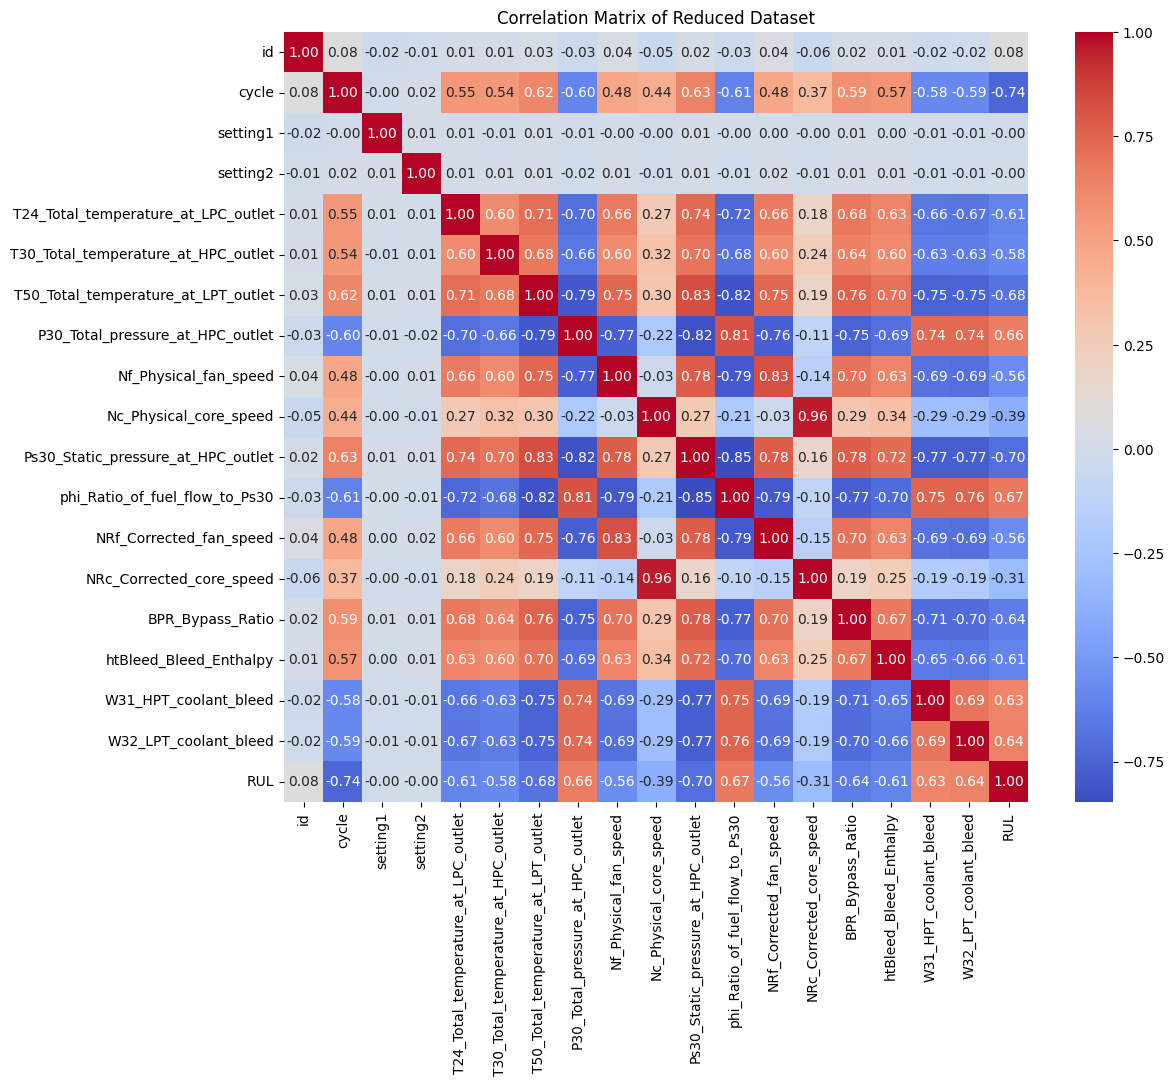

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data_reduced' is your dataframe

# Calculate the correlation matrix
correlation_matrix_reduced = df1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_reduced, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Reduced Dataset')
plt.show()

In [4]:

df = df1.drop(['setting1', 'setting2', 'Nc_Physical_core_speed', 'NRc_Corrected_core_speed'], axis=1)

df.head()

,id,cycle,T24_Total_temperature_at_LPC_outlet,T30_Total_temperature_at_HPC_outlet,T50_Total_temperature_at_LPT_outlet,P30_Total_pressure_at_HPC_outlet,Nf_Physical_fan_speed,Ps30_Static_pressure_at_HPC_outlet,phi_Ratio_of_fuel_flow_to_Ps30,NRf_Corrected_fan_speed,BPR_Bypass_Ratio,htBleed_Bleed_Enthalpy,W31_HPT_coolant_bleed,W32_LPT_coolant_bleed,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


In [5]:
features = df.drop(['id', 'cycle', 'RUL'], axis=1)
target = df['RUL']

In [6]:
scaler = MinMaxScaler()
features_norm = scaler.fit_transform(features)


In [7]:
    def create_sequences(df, features, target, cycle_length, sequence_count):
        sequences = []
        rul_values = []

        for engine_id in df['id'].unique():
            engine_data = features[df['id'] == engine_id]
            engine_rul = target[df['id'] == engine_id]

            for i in range(0, len(engine_data) - cycle_length * sequence_count + 1, cycle_length):
                seq = []
                for j in range(sequence_count):
                    seq.append(engine_data[i + j * cycle_length : i + (j + 1) * cycle_length])
                sequences.append(np.concatenate(seq))
                rul_values.append(engine_rul.iloc[i + cycle_length * sequence_count - 1])

        return np.array(sequences), np.array(rul_values)

In [8]:
cycle_length = 10
sequence_count = 3
sequences, rul_values = create_sequences(df, features_norm, target, cycle_length, sequence_count)

In [9]:
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)

X_train, X_test = sequences[:split_index], sequences[split_index:]
y_train, y_test = rul_values[:split_index], rul_values[split_index:]


In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1453, 30, 12), (364, 30, 12), (1453,), (364,))

In [11]:
normalizer = Normalization()
normalizer.adapt(X_train)

In [12]:


def build_rnn_model(input_shape):

    model = Sequential()
    model.add(normalizer)
    model.add(Bidirectional(LSTM(units=200, return_sequences=True),merge_mode='sum'))
    model.add(BatchNormalization())
    model.add(Dropout(0.05))
    model.add(Bidirectional(LSTM(units=100, return_sequences=True), merge_mode='sum'))
    model.add(Dropout(0.05))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.05))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.05))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.05))
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
    return model


    # model.compile(loss='mse', 
    #           optimizer='rmsprop',
    #          metrics=['mae', 'accuracy'])

    # model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
    # return model


input_shape = (cycle_length * sequence_count, features.shape[1])
model = build_rnn_model(input_shape)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (1453, 30, 12)         │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25 (104.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 25 (104.00 B)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [14]:
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=16, epochs=500, callbacks=[early_stopping], verbose=1)

Epoch 1/500
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 11791.5947 - mae: 90.8759 - val_loss: 14009.0947 - val_mae: 98.9341
Epoch 2/500
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 10945.5879 - mae: 87.9866 - val_loss: 13612.4336 - val_mae: 97.3762
Epoch 3/500
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 10188.5420 - mae: 84.9263 - val_loss: 12657.9170 - val_mae: 93.6475
Epoch 4/500
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 9349.7949 - mae: 81.1088 - val_loss: 10987.9531 - val_mae: 86.6837
Epoch 5/500
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 7990.5708 - mae: 73.6725 - val_loss: 7999.1323 - val_mae: 72.1860
Epoch 6/500
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 5525.0063 - mae: 59.6106 - val_loss: 5715.0444 - val_mae: 58.1994
Epoch 7/500
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 3902.8425 - mae: 46.8019 - val_loss: 4160.0420 - val_mae: 46.7092
Epoch 8/500
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 2544.1638 - mae: 35.8961 - val_loss: 3005.4329 - va

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1518.2717 - mae: 26.5027
Test Loss: [1737.955322265625, 27.77552032470703]
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Mean Absolute Error (MAE): 27.775514931469175
Mean Squared Error (MSE): 1737.9556831352338
Root Mean Squared Error (RMSE): 41.68879565465083
R2 Score: 0.673635721206665


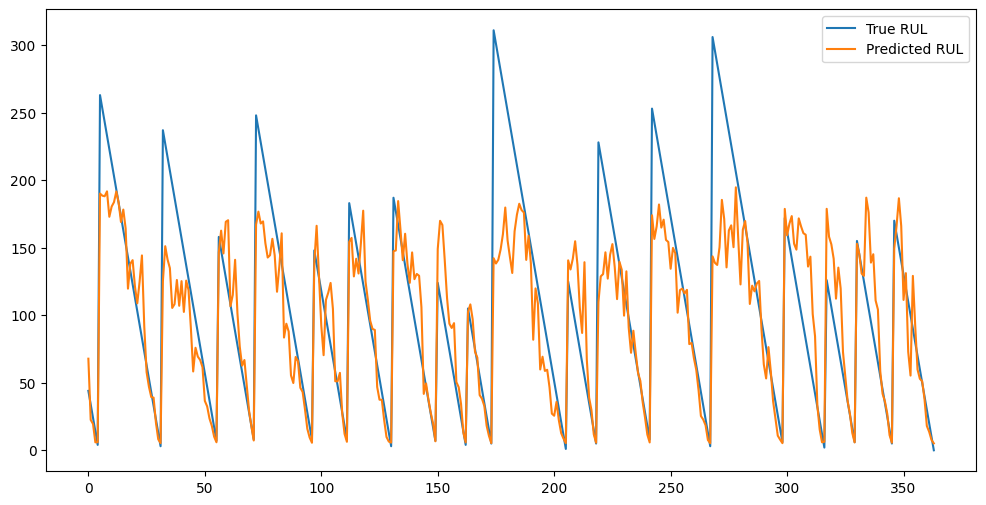

In [15]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Compute additional metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)


print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R2 Score: {r2}')

# Compare predictions to the actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True RUL')
plt.plot(predictions, label='Predicted RUL')
plt.legend()
plt.show()


In [16]:
!pwd

/Users/kieran/jet_engine
